### 3.3.1. SPARSITY OF THE ENCODED CONCEPTS

In [9]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path as osp
import matplotlib.pyplot as plt

from exp_utils import load_interactions

folders that stores the computed interaction

In [10]:
def get_folder(dataset, arch):
    return {
        "tictactoe | MLP-5":
            "../saved-interactions/dataset=tictactoe_balance_model=mlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "tictactoe | ResMLP-5":
            "../saved-interactions/dataset=tictactoe_balance_model=resmlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "wifi | MLP-5":
            "../saved-interactions/dataset=wifi_balance_model=mlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "wifi | ResMLP-5":
            "../saved-interactions/dataset=wifi_balance_model=resmlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "simpleisthree | LeNet":
            "../saved-interactions/dataset=simpleisthree_model=lenet_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-20":
            "../saved-interactions/dataset=simpleisthree_model=resnet20_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-32":
            "../saved-interactions/dataset=simpleisthree_model=resnet32_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-44":
            "../saved-interactions/dataset=simpleisthree_model=resnet44_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | VGG-13":
            "../saved-interactions/dataset=simpleisthree_model=vgg13_bn_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | VGG-16":
            "../saved-interactions/dataset=simpleisthree_model=vgg16_bn_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | AlexNet":
            "../saved-interactions/dataset=celeba_eyeglasses_model=alexnet_epoch=20_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | ResNet-18":
            "../saved-interactions/dataset=celeba_eyeglasses_model=resnet18_epoch=20_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | ResNet-34":
            "../saved-interactions/dataset=celeba_eyeglasses_model=resnet34_epoch=20_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "shapenet | PointNet":
            "../saved-interactions/dataset=shapenet_model=pointnet_epoch=200_bs=32_lr=0.01_logspace=1_seed=0/dim=gt-log-odds-v0_baseline=center_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "shapenet | PointNet++":
            "../saved-interactions/dataset=shapenet_model=pointnet2_epoch=200_bs=32_lr=0.01_logspace=1_seed=0/dim=gt-log-odds-v0_baseline=center_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
    }[f"{dataset} | {arch}"]

compute the normalized interaction strength of different concepts $|\tilde{I}(S|\boldsymbol{x})|\!\triangleq\! |I(S|\boldsymbol{x})|/\max_{S'}|I(S'|\boldsymbol{x})|$ in a descending order.

In [11]:
def extract_interaction_strength(interaction_dict):
    all_interactions = []
    for key_1 in interaction_dict.keys():
        for key_2 in interaction_dict[key_1].keys():
            I_and, I_or = interaction_dict[key_1][key_2]
            I_strength = torch.abs(torch.cat([I_and, I_or]))
            I_strength = I_strength / (I_strength.max() + 1e-7)
            I_strength = I_strength[torch.argsort(-I_strength)]
            all_interactions.append(I_strength)
    all_interactions = torch.stack(all_interactions)

    mean = torch.mean(all_interactions, dim=0)
    return mean

plot the normalized interaction strength

In [12]:
def ax_plot_curve(ax: plt.Axes, plot_dict: dict, title: str):
    for i, (key, strength) in enumerate(plot_dict.items()):
        if isinstance(strength, torch.Tensor):
            strength = strength.detach().cpu().numpy()
        X = torch.arange(strength.shape[0])
        ax.plot(X, strength, label=key)
    ax.set_title(title, style="italic")
    ax.set_xlabel("index of interaction\n" + r"concepts $S$")
    ax.set_ylabel("normalized interaction\n" + r"strength $|\tilde{I}(S)|$")
    ax.set_yticks([0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, "", 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.axhline(0.05, color="gray", alpha=0.5, linestyle="dotted")
    ax.legend()

plot for each DNN

In [13]:
configs = [
    dict(
        dataset   = "tictactoe",
        arch_list = ["MLP-5", "ResMLP-5"],
        title     = "tic-tac-toe",
    ),
    dict(
        dataset   = "wifi",
        arch_list = ["MLP-5", "ResMLP-5"],
        title     = "wifi",
    ),
    dict(
        dataset   = "simpleisthree",
        arch_list = ["LeNet", "ResNet-20", "ResNet-32", "ResNet-44", "VGG-13", "VGG-16"],
        title     = "MNIST-3"
    ),
    dict(
        dataset   = "celeba_eyeglasses",
        arch_list = ["AlexNet", "ResNet-18", "ResNet-34"],
        title     = "CelebA-eyeglasses",
    ),
    dict(
        dataset   = "shapenet",
        arch_list = ["PointNet", "PointNet++"],
        title     = "ShapeNet"
    )
]

loading: 100%|██████████████| 50/50 [00:00<00:00, 892.93it/s, --> LOADING sample_00999 FROM class_1]
loading: 100%|█| 99/99 [00:00<00:00, 830.55it/s, --> LOADING sample_fad668ac64ccea1ab37378f3c85478b4
loading: 100%|█| 99/99 [00:00<00:00, 853.40it/s, --> LOADING sample_fad668ac64ccea1ab37378f3c85478b4


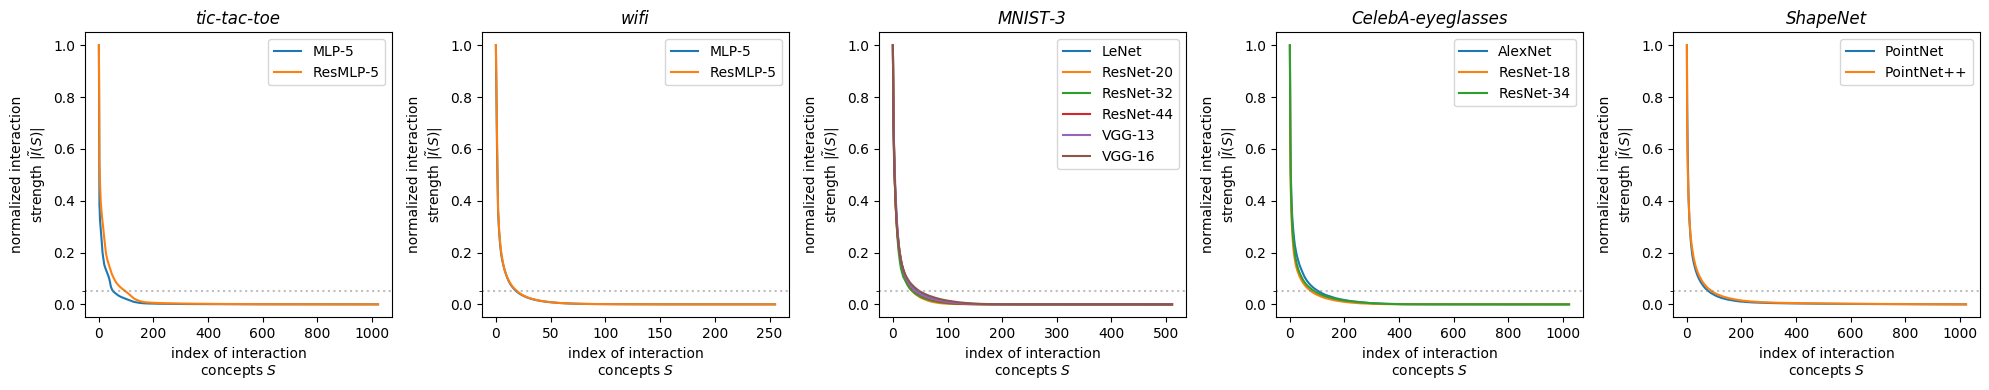

In [14]:
fig, axes = plt.subplots(1, len(configs), figsize=(4 * len(configs), 4))
for i, config in enumerate(configs):
    dataset = config["dataset"]
    arch_list = config["arch_list"]
    title = config["title"]
    interaction_strength = {}
    for arch in arch_list:
        folder = get_folder(dataset, arch)
        interaction_dict = load_interactions(dataset, folder)
        strength = extract_interaction_strength(interaction_dict)
        interaction_strength[arch] = strength
    ax_plot_curve(axes[i], interaction_strength, title=title)
plt.tight_layout()
plt.show()